<a href="https://colab.research.google.com/github/idancz/Gigantic_MuMIMO_ViterbiBasedNet/blob/master/main_including_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone "https://github.com/idancz/Gigantic_MuMIMO_ViterbiBasedNet.git"
from google.colab import drive
import os
import sys
path = "/content/Gigantic_MuMIMO_ViterbiBasedNet"
%cd $path
%ls -a
# importing all links
def add_directory(curr_dir):
  for dir_name in os.listdir(curr_dir):        
    dir_path = os.path.join(curr_dir, dir_name)   
    if os.path.isdir(dir_path):
      #print("adding directory "+dir_path+"...")
      sys.path.insert(0, dir_path)    
      add_directory(dir_path)
# add all directory to OS path recursively
add_directory("./")

Cloning into 'Gigantic_MuMIMO_ViterbiBasedNet'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 61 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.
/content/Gigantic_MuMIMO_ViterbiBasedNet
./   Code/                             .git/            Readme.pdf  Results/
../  Gigantic_MuMIMO_ViterbiBasedNet/  project_env.yml  Resources/


Streaming output truncated to the last 5000 lines.
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 1.0)
***********************************
Current word: (129, 0.0, 1.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 0.0)
***********************************
Current word: (131, 0.0, 0.0)
***********************************
Current word: (132, 0.0, 2.0)
***********************************
Current word: (133, 0.0, 0.0)
***********************************
Current word: (134, 0.0, 1.0)
***********************************
Current word: (135, 0.0, 0.0)
***********************************
Current word: (136, 0.0, 0.0)
***********************************
Current word: (137, 0.0, 0.0)
***********************************
Current word: (138, 0.0, 1.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current

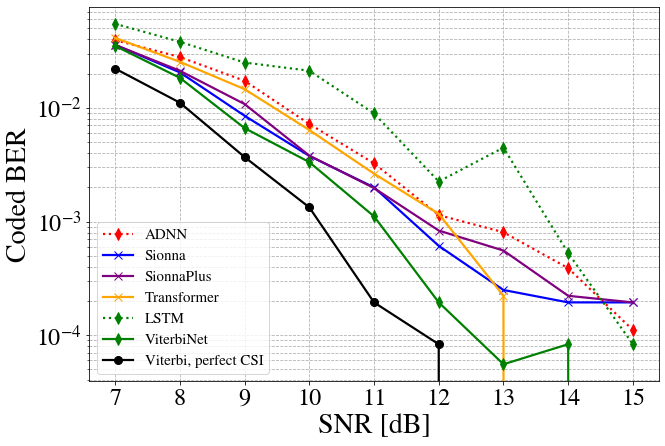

In [4]:
from Code.dir_definitions import *
from Code.plotter import get_ser_data, plot_ser_by_block_index, plot_ser_by_snr
from Code.trainer import Trainer

def execute_and_plot(model_name, detector_method, self_supervised, all_curves, current_params, run_over):
    method_name = model_name + "_" + detector_method
    trainer = Trainer(
                    model_name=model_name,
                    detector_method=detector_method,
                    self_supervised=self_supervised,
                    weights_dir=os.path.join(WEIGHTS_DIR,
                    f'{method_name}_training_{HYPERPARAMS_DICT["val_block_length"]}_{HYPERPARAMS_DICT["n_symbols"]}_channel1_{HYPERPARAMS_DICT["channel_coefficients"]}'),
                    **HYPERPARAMS_DICT)

    ser = get_ser_data(trainer, run_over=run_over, method_name=method_name + '_' + current_params)
    all_curves.append((ser, model_name, HYPERPARAMS_DICT['val_block_length'], HYPERPARAMS_DICT['n_symbols']))


HYPERPARAMS_DICT = {
                    'noisy_est_var': 0,
                    'fading_taps_type': 1,  # 1 / 2  for time decay only
                    'fading_in_channel': True,
                    'fading_in_decoder': True,
                    'gamma': 0.2,
                    'channel_type': 'ISI_AWGN',
                    'val_frames': 12,  # up to 12 for cost2100
                    'subframes_in_frame': 25,  # up to 25 for cost2100
                    'self_supervised_iterations': 200,
                    'ser_thresh': 0.02,  # ser threshold for online training
                    'train_minibatch_num': 25,  # 25
                    }


if __name__ == '__main__':
    # main flags
    run_over = 2  # 0 - load plots from previous runs / 1 - load trained weights and start online evaluation / 2 - clear all and start training  from scratch
    plot_by_block = False  # False / True either plot by SNR or by block index
    block_length = 120     # determine the transmission length
    channel_coefficients = 'cost2100'  # 'time_decay' / 'cost2100'
    n_symbol = 2
    snr_start, snr_end = 7, 15

    # deep learning models list 'ADNN', 'Sionna', 'SionnaPlus', 'Transformer', 'LSTM', 'ViterbiNet'
    models_list = ['ADNN', 'Sionna', 'SionnaPlus', 'Transformer', 'LSTM', 'ViterbiNet']
    detector_method = 'ModelBased'  # ModelBased / EndToEnd / Statistical
    self_supervised = True  # True / False for online evaluation enablement

    all_curves = []

    for snr in range(snr_start, snr_end+1):
        print(snr, block_length, n_symbol)

        HYPERPARAMS_DICT['n_symbols'] = n_symbol
        HYPERPARAMS_DICT['curr_SNR'] = snr
        HYPERPARAMS_DICT['val_block_length'] = block_length
        HYPERPARAMS_DICT['train_block_length'] = block_length
        HYPERPARAMS_DICT['fading_in_channel'] = True if channel_coefficients == 'time_decay' else False
        HYPERPARAMS_DICT['channel_coefficients'] = channel_coefficients

        current_params = HYPERPARAMS_DICT['channel_coefficients'] + '_' + str(HYPERPARAMS_DICT['curr_SNR']) + '_' + \
                         str(HYPERPARAMS_DICT['val_block_length']) + '_' + str(HYPERPARAMS_DICT['n_symbols'])

        for model in models_list:
            execute_and_plot(model, detector_method, self_supervised, all_curves, current_params, run_over)

        execute_and_plot('ClassicViterbi', 'Statistical', False, all_curves, current_params, run_over)  # Classic Viterbi Alg with Perfect-CSI

        if plot_by_block:
            plot_ser_by_block_index(all_curves, block_length, n_symbol, snr)

    snr_values = [s for s in range(snr_start, snr_end+1)]
    if not plot_by_block:
        plot_ser_by_snr(all_curves, snr_values)

In [1]:
#@title displaying tabular results
import torch
import numpy as np
import pandas as pd
models_list = ['ADNN', 'Sionna', 'SionnaPlus', 'Transformer','LSTM', 'ViterbiNet']
df = pd.DataFrame(all_curves,columns =['BER', 'NET','InfoBits', 'Modulation'])
#adnn = df[df.NET == 'ADNN']
#model_ber = df[df.NET == model]
#model_ber.index = snr_values
#adnn.mean(axis = 1, skipna = True)
results = np.zeros((len(snr_values),len(models_list)))
i=0
j=0
for snr in snr_values:    
    j=0
    for model in models_list:  
      #print(j)
      model_ber = df[df.NET == model]
      model_ber.index = snr_values
      results[i,j] = model_ber[['BER']].loc[snr].mean(axis = 0, skipna = True).mean()
      j+=1      
    i+=1
res = pd.DataFrame(results,columns=models_list)
res.index = snr_values
print(res)

NameError: ignored